# Problem Statement
### Upgrade propensity model

In this task, the goal is to predict the overall rating of customers using the review and summary information.

### Task list
Data exploration, data cleaning and feature engineering. Remember to comment each step properly.
Explanatory analysis. Include key insights in the presentation
Modelling/Training
Prepare a presentation and present the analysis. Use visualisations and tell compelling stories. Tell us what is the message(s) for the business? What actionable insights you can provide to the business?

### Required Output
Fully commented code
Modelling dataset (json file)
Visualisation tool files (if anything)
Slides of presentations, including but not limited to:
Problem statement, Assumptions, Hypotheses
Exploratory analysis
Modelling approach
Results
Model performance measures
Business audience performance measures
Insights
Recommendations

# Data Exploration and Preparation

## Loading the data

- This section includes loading of the data, understanding basic description of the data; followed by cleanup & imputations if required.

In [54]:
# Importing the required packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter

import re
import string

import nltk
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score,precision_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
# import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading at the data and looking at the shape

review_data = pd.read_json('data/Musical_Instruments_5.json', lines=True)
print('Shape of data is:', review_data.shape)

Shape of data is: (10261, 9)


In [3]:
review_data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5,No more pops when I record my vocals.,1392940800,"02 21, 2014"


## Variable Identification

In [4]:
# Looking at individual features
review_data.dtypes

reviewerID        object
asin              object
reviewerName      object
helpful           object
reviewText        object
overall            int64
summary           object
unixReviewTime     int64
reviewTime        object
dtype: object

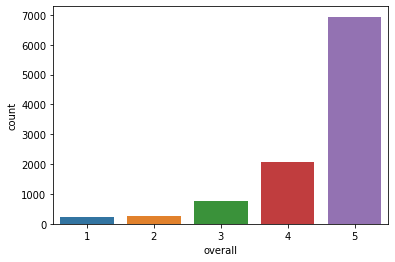

In [5]:
# Checking the count of unique target values

sns.countplot(review_data['overall']);
# c = Counter(review_data['overall'])
# [(i, c[i] / len(review_data['overall']) * 100.0) for i, count in c.most_common()]

In [6]:
# Checking for unique values

review_data.loc[:,['reviewerID', 'asin', 'reviewerName', 'reviewText', 'overall', 'summary']].nunique()

reviewerID       1429
asin              900
reviewerName     1397
reviewText      10255
overall             5
summary          8852
dtype: int64

In [7]:
# Checking nan values across dataset

review_data.isna().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         0
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

In [8]:
# Removing uneccessary columns for now

review_data.drop(labels=['reviewerID', 'asin', 'reviewerName', 'helpful', 'unixReviewTime', 'reviewTime'], axis=1, inplace=True)

In [9]:
# Combining summary and  reviewText

review_data['text'] = review_data['summary'] + ' ' + review_data['reviewText']
review_data.drop(labels=['summary', 'reviewText'], axis=1, inplace=True)
review_data.head()

,overall,text
0,5,"good Not much to write about here, but it does..."
1,5,Jake The product does exactly as it should and...
2,5,It Does The Job Well The primary job of this d...
3,5,GOOD WINDSCREEN FOR THE MONEY Nice windscreen ...
4,5,No more pops when I record my vocals. This pop...


In [10]:
review_data.shape

(10261, 2)

#### Initial Observations:

- There are a total of 10261 records and 9 features. However, for this problem we shall be taking into account the summary, reviewtext and overall.
- There is noticable imbalance 5 and 4 ratings at 87 percent and the remaining 13 percent are covered with 1,2,3 ratings. 

In [11]:
review_data['text'][1]

"Jake The product does exactly as it should and is quite affordable.I did not realized it was double screened until it arrived, so it was even better than I had expected.As an added bonus, one of the screens carries a small hint of the smell of an old grape candy I used to buy, so for reminiscent's sake, I cannot stop putting the pop filter next to my nose and smelling it after recording. :DIf you needed a pop filter, this will work just as well as the expensive ones, and it may even come with a pleasing aroma like mine did!Buy this product! :]"

### Data Preprocessing

In [12]:
# function to remove punctuations
# string.punctuation
def remove_punctuation(text):
#     no_punct = "".join([c for c in text if c not in string.punctuation])
#     return no_punct
    string1 = text.lower()
    translation_table = dict.fromkeys(map(ord, string.punctuation),' ')
    string2 = string1.translate(translation_table)
    return string2

review_data['text'] = review_data['text'].apply(lambda x: remove_punctuation(x))
review_data['text'][1]

'jake the product does exactly as it should and is quite affordable i did not realized it was double screened until it arrived  so it was even better than i had expected as an added bonus  one of the screens carries a small hint of the smell of an old grape candy i used to buy  so for reminiscent s sake  i cannot stop putting the pop filter next to my nose and smelling it after recording   dif you needed a pop filter  this will work just as well as the expensive ones  and it may even come with a pleasing aroma like mine did buy this product    '

In [13]:
# function to remove stop words
# stopwords.words('english')

def remove_stopwords(text):
#     return [w for w in text if w not in stopwords.words('english')]
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    string2 = pattern.sub(' ', text)
    return string2

review_data['text'] = review_data['text'].apply(lambda x: remove_stopwords(x))
review_data['text'][1]

'jake  product  exactly      quite affordable    realized   double screened   arrived     even better    expected   added bonus  one   screens carries  small hint   smell   old grape candy  used  buy    reminiscent  sake   cannot stop putting  pop filter next   nose  smelling   recording   dif  needed  pop filter    work   well   expensive ones    may even come   pleasing aroma like mine  buy  product    '

In [14]:
# function to tokenize
def tokenize_words(text):
    return nltk.word_tokenize(text)

review_data['text'] = review_data['text'].apply(lambda x: tokenize_words(x.lower()))
review_data['text'][1]

['jake',
 'product',
 'exactly',
 'quite',
 'affordable',
 'realized',
 'double',
 'screened',
 'arrived',
 'even',
 'better',
 'expected',
 'added',
 'bonus',
 'one',
 'screens',
 'carries',
 'small',
 'hint',
 'smell',
 'old',
 'grape',
 'candy',
 'used',
 'buy',
 'reminiscent',
 'sake',
 'can',
 'not',
 'stop',
 'putting',
 'pop',
 'filter',
 'next',
 'nose',
 'smelling',
 'recording',
 'dif',
 'needed',
 'pop',
 'filter',
 'work',
 'well',
 'expensive',
 'ones',
 'may',
 'even',
 'come',
 'pleasing',
 'aroma',
 'like',
 'mine',
 'buy',
 'product']

In [15]:
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

#Lemmatization
def lemmatize_words(data_str):
# expects a string
    list_pos = 0
    cleaned_str = ''
    final_text=[]
    lmtzr = WordNetLemmatizer()
    stop = set(stopwords.words('english'))
    punc = list(string.punctuation)
    stop.update(punc)
    for i in data_str:
        if i.strip().lower() not in stop:
            pos = pos_tag([i.strip()])
            if get_simple_pos(pos[0][1]) is None:
                pass
            else:
                word = lmtzr.lemmatize(i.strip(),get_simple_pos(pos[0][1]))
                final_text.append(word.lower())
    return " ".join(final_text)

In [16]:
review_data['text'] = review_data['text'].apply(lambda x: lemmatize_words(x))
review_data['text'][1]

'jake product exactly quite affordable realize double screen arrive even well expect add bonus screen carry small hint smell old grape candy use buy reminiscent sake stop put pop filter next nose smell record dif need pop filter work well expensive one even come please aroma mine buy product'

In [17]:
review_data.head()

,overall,text
0,5,good much write exactly suppose filter pop sou...
1,5,jake product exactly quite affordable realize ...
2,5,job well primary job device block breath other...
3,5,good windscreen money nice windscreen protects...
4,5,pop record vocal pop filter great look perform...
...,...,...
10256,5,star great expect thank
10257,5,long life player good economic choice think tr...
10258,4,good coat try coat string past include elixir ...
10259,4,taylor make well make elixir developed taylor ...


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X_data = tfidf.fit_transform(review_data['text'])

In [19]:
X_data

<10261x15777 sparse matrix of type '<class 'numpy.float64'>'
	with 359658 stored elements in Compressed Sparse Row format>

In [26]:
y_data = review_data['overall']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state= 45)

In [30]:
from keras.utils import np_utils
y_train_updated = np_utils.to_categorical(y_train)
y_test_updated = np_utils.to_categorical(y_test)
num_classes = y_test_updated.shape[1]

In [43]:
# Create the model
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation

model = Sequential()

model.add(Dense(units = 75 , activation = 'relu' , input_dim = X_train.shape[1]))
model.add(Dense(units = 50 , activation = 'relu'))
model.add(Dense(units = 25 , activation = 'relu'))
model.add(Dense(units = 10 , activation = 'relu')) 
model.add(Dense(units = 6, activation = 'sigmoid'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])


In [ ]:
# model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:], padding='same'))
# model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())

In [ ]:
# model.add(Conv2D(64, (3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())

In [ ]:
# model.add(Conv2D(128, (3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())

In [ ]:
# model.add(Flatten())
# model.add(Dropout(0.2))

In [ ]:
# model.add(Dense(256, kernel_constraint=maxnorm(3)))
# model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())

In [ ]:
# model.add(Dense(128, kernel_constraint=maxnorm(3)))
# model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())

In [ ]:
# model.add(Dense(num_classes))
# model.add(Activation('softmax'))

In [38]:
epochs = 5
optimizer = 'Adam'

In [ ]:
# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [44]:
model.fit(X_train, y_train_updated, validation_data=(X_test, y_test_updated), epochs=epochs, batch_size=64)

Train on 7695 samples, validate on 2566 samples
Epoch 1/5
7695/7695 [==============================] - 4s 562us/step - loss: 0.4345 - accuracy: 0.8892 - val_loss: 0.3219 - val_accuracy: 0.8965
Epoch 2/5
7695/7695 [==============================] - 4s 509us/step - loss: 0.2841 - accuracy: 0.8906 - val_loss: 0.2667 - val_accuracy: 0.8965
Epoch 3/5
7695/7695 [==============================] - 4s 482us/step - loss: 0.2036 - accuracy: 0.9093 - val_loss: 0.2495 - val_accuracy: 0.8966
Epoch 4/5
7695/7695 [==============================] - 3s 453us/step - loss: 0.1532 - accuracy: 0.9297 - val_loss: 0.2937 - val_accuracy: 0.8882
Epoch 5/5
7695/7695 [==============================] - 4s 462us/step - loss: 0.1240 - accuracy: 0.9426 - val_loss: 0.3476 - val_accuracy: 0.8851


In [45]:
scores = model.evaluate(X_test, y_test_updated, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 88.51%


In [49]:
yhat_probs = model.predict(X_test)

In [48]:
yhat_classes = model.predict_classes(X_test, verbose=0)

In [56]:
# reduce to 1d array
# yhat_probs = yhat_probs[:, 0]
# yhat_classes = yhat_classes[:, 0]

In [55]:
# print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_updated, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_updated, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_updated, yhat_classes)
print('F1 score: %f' % f1)

ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

## Model Selection

### LSTM

In [22]:
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

embedding_size=32
max_words=5000

model = Sequential()
model.add(Embedding(max_words, embedding_size, input_length=X_train.shape[1]))
model.add(LSTM(100))
model.add(Dense(5,activation='softmax'))

print(model.summary())

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 15777, 32)         160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 213,705
Trainable params: 213,705
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [24]:
# converting categorical variables in y_train to numerical variables
y_train_dummies = pd.get_dummies(y_train).values
print('Shape of Label tensor: ', y_train_dummies.shape)

Shape of Label tensor:  (7695, 5)


In [25]:
#train the model
model.fit(X_train, y_train_dummies, epochs=5, batch_size=32)
#model.sav('MusicalInstrumentReviews.h5')

Epoch 1/5
 928/7695 [==>...........................] - ETA: 14:33:53 - loss: 1.1392 - accuracy: 0.6670

KeyboardInterrupt: 

In [ ]:
model.save('MusicalInstrumentReviews.h5')

In [ ]:
# converting categorical variables in y_train to numerical variables
y_test_dummies = pd.get_dummies(y_test).values
print('Shape of Label tensor: ', y_test_dummies.shape)

In [ ]:
# model evaluation
from keras.models import load_model

model = load_model('MusicalInstrumentReviews.h5')
scores = model.evaluate(X_test, y_test_dummies)

LSTM_accuracy = scores[1]*100

print('Test accuracy: ', scores[1]*100, '%')

## Naive Bayes

In [ ]:
# Instatiation, fitting and prediction

MNB = MultinomialNB()
MNB.fit(X_train, y_train)
predictions = MNB.predict(X_test)

In [ ]:
# Model evaluation

print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

MNB_f1 = round(f1_score(y_test, predictions, average='weighted'), 3)
MNB_accuracy = round((accuracy_score(y_test, predictions)*100),2)

print("Accuracy : " , MNB_accuracy , " %")
print("f1_score : " , MNB_f1)

## XGBoost

In [ ]:
# Instatiation, fitting and predictions

xgb_ = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',
 nthread=4,
 scale_pos_weight=1,
 seed= 45)

xgb_.fit(X_train, y_train)
predictions = xgb_.predict(X_test)

In [ ]:
# Model evaluation
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

xgb_f1 = round(f1_score(y_test, predictions, average= 'weighted'), 3)
xgb_accuracy = round((accuracy_score(y_test, predictions) * 100), 2)

print("Accuracy : " , xgb_accuracy , " %")
print("f1_score : " , xgb_f1)